# Generative AI
## Results such as plots and models are saved in following dirs
- mnist_digits/
- mnist_fashion/
- anime-faces/

In this notebook, Generative Adversarial Networks (GAN) will be used to create new images.

* Train GAN for MNIST (1,5P)
* Apply GAN on Fashion MNIST (1P)
* Apply GAN on another dataset (1,5P)

## GAN - MNIST

Train a GAN network to create new instances of the MNIST dataset. You can follow a tutorial such as [Example Tutorial](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) to complete this task. However, it is important that you comment your code and describe your observations. 

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


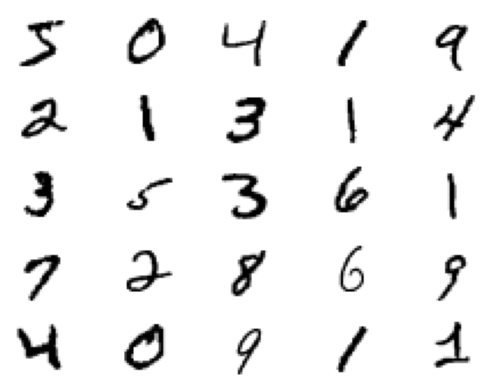

In [35]:
from keras.datasets.mnist import load_data
from matplotlib import pyplot

(trainX, trainy), (testX, testy) = load_data()
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

for i in range(25):
 pyplot.subplot(5, 5, 1 + i)
 pyplot.axis('off')
 pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [49]:
from keras.models import Sequential
from keras.optimizers.legacy import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils import plot_model
from numpy import expand_dims
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy import vstack
from numpy.random import randn
from numpy.random import rand
from numpy.random import randint
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

In [40]:
# define the standalone discriminator model
# takes image as an input and classifies if real or fake
# mutliple layers, after conv2d layer comes an activation function
def define_discriminator(in_shape=(28,28,1)):
 model = Sequential()
 model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Dropout(0.4))
 model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Dropout(0.4))
 model.add(Flatten())
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 opt = Adam(learning_rate=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 return model

# load and prepare mnist training images
def load_real_samples():
 (trainX, _), (_, _) = load_data()
 # cond2d needs 3d data, expand to 3d, e.g. add channels dimension
 X = expand_dims(trainX, axis=-1)
 # convert from unsigned ints to floats
 X = X.astype('float32')
 # scale from [0,255] to [0,1]
 X = X / 255.0
 return X


# a function that selects real saamples from the dataset
def generate_real_samples(dataset, n_samples):
 # choose random instances
 ix = randint(0, dataset.shape[0], n_samples)
 # retrieve selected images
 X = dataset[ix]
 # generate 'real' class labels (1), label that indicates if sample is real or fake
 y = ones((n_samples, 1))
 return X, y


# generate n fake samples with class labels, generating random fake samples
def generate_fake_samples_mock(n_samples):
 # generate uniform random numbers in [0,1]
 X = rand(28 * 28 * n_samples)
 # reshape into a batch of grayscale images
 X = X.reshape((n_samples, 28, 28, 1))
 # generate 'fake' class labels (0)
 y = zeros((n_samples, 1))
 return X, y

def train_discriminator_with_mock(model, dataset, n_iter=100, n_batch=256):
 half_batch = int(n_batch / 2)
 # half of batch is real and half is fake samples
 # manually enumerate epochs
 for i in range(n_iter):
  # get randomly selected 'real' samples
  X_real, y_real = generate_real_samples(dataset, half_batch)
 # update discriminator on real samples
  _, real_acc = model.train_on_batch(X_real, y_real)
 # generate 'fake' examples
  X_fake, y_fake = generate_fake_samples_mock(half_batch)
  # update discriminator on fake samples
  _, fake_acc = model.train_on_batch(X_fake, y_fake)
  # summarize performance
  print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [25]:
disc_model = define_discriminator()
disc_model.summary()
plot_model(disc_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

dataset = load_real_samples()
train_discriminator_with_mock(disc_model, dataset)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_14 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 dropout_15 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 flatten_7 (Flatten)         (None, 3136)             

In [45]:
# define the standalone generator model
# generator models is trained to generate fake samples
# fakes should be so good that discriminator cannot tell that they are fake
def define_generator(latent_dim):
 model = Sequential()
 # foundation for 7x7 image
 n_nodes = 128 * 7 * 7
 model.add(Dense(n_nodes, input_dim=latent_dim))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Reshape((7, 7, 128)))
 # upsample to 14x14
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # upsample to 28x28
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
 return model

# to generate samples with generator, takes latent vector as input
def generate_latent_points(latent_dim, n_samples):
 # generate points in the latent space
 x_input = randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 x_input = x_input.reshape(n_samples, latent_dim)
 return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
 # generate points in latent space
 x_input = generate_latent_points(latent_dim, n_samples)
 # predict outputs
 X = g_model.predict(x_input)
 # create 'fake' class labels (0)
 y = zeros((n_samples, 1))
 return X, y

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_14 (Reshape)        (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_70 (Conv2  (None, 14, 14, 128)       262272    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_71 (Conv2  (None, 28, 28, 128)       262272    
 DTranspose)                                         

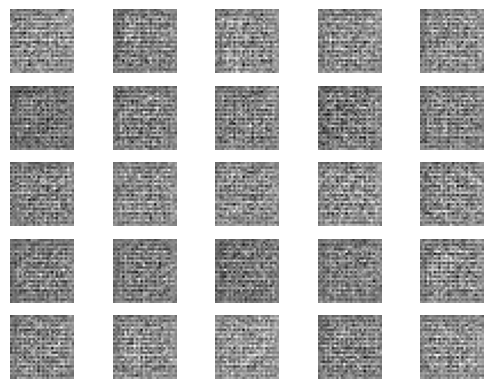

images produced seem really fake/random, untrained generator model does not produce plausible images


In [46]:
# creating samples with untrained generator model

latent_dim = 100
gen_model = define_generator(latent_dim)
gen_model.summary()
plot_model(gen_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)
n_samples = 25
X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
 # define subplot
 pyplot.subplot(5, 5, 1 + i)
 # turn off axis labels
 pyplot.axis('off')
 # plot single image
 pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()

print("images produced seem really fake/random, untrained generator model does not produce plausible images")

In [47]:
# define the combined generator and discriminator model, for updating the generator
# generator produces images, discriminator tells if images are fake or not,
# if fake the weights of generator are updated
def define_gan(g_model, d_model):
 # make weights in the discriminator not trainable
 d_model.trainable = False
 # connect them
 model = Sequential()
 # add generator
 model.add(g_model)
 # add the discriminator
 model.add(d_model)
 # compile model
 opt = Adam(learning_rate=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt)
 return model

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
 bat_per_epo = int(dataset.shape[0] / n_batch)
 half_batch = int(n_batch / 2)
 # manually enumerate epochs
 for i in range(n_epochs):
 # enumerate batches over the training set
  for j in range(bat_per_epo):
 # get randomly selected 'real' samples
   X_real, y_real = generate_real_samples(dataset, half_batch)
 # generate 'fake' examples
   X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
 # create training set for the discriminator
   X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
 # update discriminator model weights
   d_loss, _ = d_model.train_on_batch(X, y)
 # prepare points in latent space as input for the generator
   X_gan = generate_latent_points(latent_dim, n_batch)
 # create inverted labels for the fake samples
   y_gan = ones((n_batch, 1))
 # update the generator via the discriminator's error
   g_loss = gan_model.train_on_batch(X_gan, y_gan)
 # summarize loss on this batch
   print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

  if (i+1) % 10 == 0:
    print("saving")
    summarize_performance(i, g_model, d_model, dataset, latent_dim)


# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
 # plot images
 for i in range(n * n):
 # define subplot
  pyplot.subplot(n, n, 1 + i)
 # turn off axis
  pyplot.axis('off')
 # plot raw pixel data
  pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
 # save plot to file
 filename = 'generated_plot_e%03d.png' % (epoch+1)
 pyplot.savefig(filename)
 pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
 # prepare real samples
 X_real, y_real = generate_real_samples(dataset, n_samples)
 # evaluate discriminator on real examples
 _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
 # prepare fake examples
 x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
 # evaluate discriminator on fake examples
 _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
 # summarize discriminator performance
 print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
 # save plot
 save_plot(x_fake, epoch)
 # save the generator model tile file
 filename = 'generator_model_%03d.h5' % (epoch + 1)
 g_model.save(filename)

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_41 (Sequential)  (None, 28, 28, 1)         1164289   
                                                                 
 sequential_40 (Sequential)  (None, 1)                 40705     
                                                                 
Total params: 1204994 (4.60 MB)
Trainable params: 1164289 (4.44 MB)
Non-trainable params: 40705 (159.00 KB)
_________________________________________________________________
result after 30 epochs of training, other results found in mnist_digits/ directory


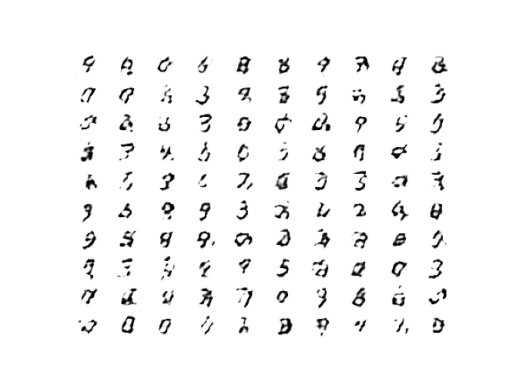

In [52]:
latent_dim = 100
dataset = load_real_samples()
d_model = define_discriminator()
g_model = define_generator(latent_dim)
# combine
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

# train(g_model, d_model, gan_model, dataset[:5000], latent_dim, 30, 64)

print("result after 30 epochs of training, other results found in mnist_digits/ directory")
img = mpimg.imread("./mnist_digits/generated_plot_e030.png")

plt.imshow(img)
plt.axis('off') 
plt.show()

## GAN - Fashion MNIST

Download the [Fashion MNIST dataset](https://www.kaggle.com/datasets/zalando-research/fashionmnist) and visualize a few instances. 
Apply the code from the previous task on this dataset and create new data. Document your observations. 

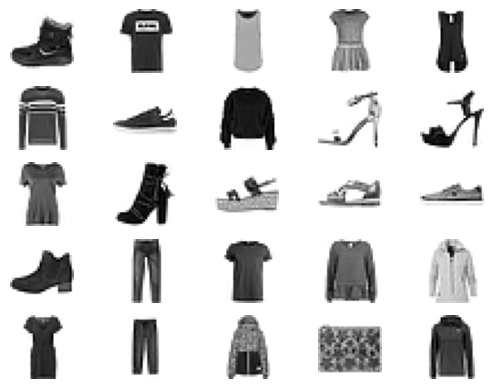

In [6]:
from keras.datasets import fashion_mnist

def load_real_samples():
    (trainX, _), (_, _) = fashion_mnist.load_data()
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32') / 255.0
    return X

samples = load_real_samples()

for i in range(25):
 pyplot.subplot(5, 5, 1 + i)
 pyplot.axis('off')
 pyplot.imshow(samples[i], cmap='gray_r')
pyplot.show()

result after 30 epochs of training, other results found in mnist_digits/ directory


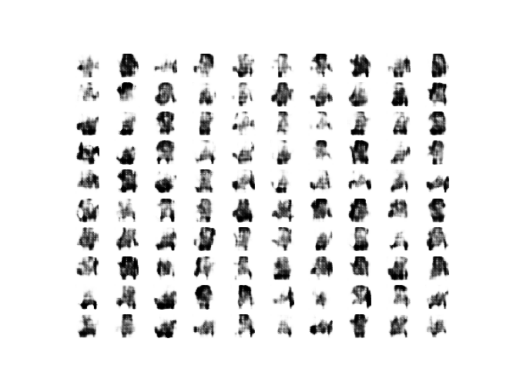

In [51]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
# train(g_model, d_model, gan_model, dataset[:5000], latent_dim, 30, 128)

print("result after 30 epochs of training, other results found in mnist_fashion/ directory")
img = mpimg.imread("./mnist_fashion/generated_plot_e030.png")

plt.imshow(img)
plt.axis('off')  
plt.show()


## GAN - Your dataset

Find a dataset by yourself and create new instances with GAN. Document your observations. 

In [33]:
# results in anime-faces directory
# https://www.kaggle.com/code/amirhosseinmirzaie/anime-character-generation-gan
from keras.utils import image_dataset_from_directory
from keras import layers, Model
import tensorflow as tf

image_size = 64
latent_size = 128
batch_size = 128
epochs = 25
lr = 0.0002

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(image_size, image_size, 3)),
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(1, (4, 4), padding='valid', use_bias=False),
        layers.Flatten(),
        layers.Activation('sigmoid')
    ])
    return model

def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_size,)),
        layers.Reshape((1, 1, latent_size)),
        
        layers.Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='valid', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.Activation('tanh')
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()
generator = build_generator()
generator.summary()
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)

anime_faces = image_dataset_from_directory(directory="./anime-faces-images/", image_size=(64,64), batch_size=64, label_mode=None)
train_dataset = anime_faces.map(lambda x: (x - 127.5) / 127.5)
train_dataset = train_dataset.take(100)

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


for epoch in range(epochs):
    print("epoch", epoch)
    batch_count = 0  
    for image_batch in train_dataset:
        batch_count += 1
        print("\nBatch", batch_count)
        train_step(image_batch)
    if epoch == epochs - 1:
        generator.save("anime-faces")

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 32, 32, 64)        3072      
                                                                 
 batch_normalization_104 (B  (None, 32, 32, 64)        256       
 atchNormalization)                                              
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_66 (Conv2D)          (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_105 (B  (None, 16, 16, 128)       512       
 atchNormalization)                                              
                                                                 
 leaky_re_lu_53 (LeakyReLU)  (None, 16, 16, 128)     

Found 63565 files belonging to 1 classes.


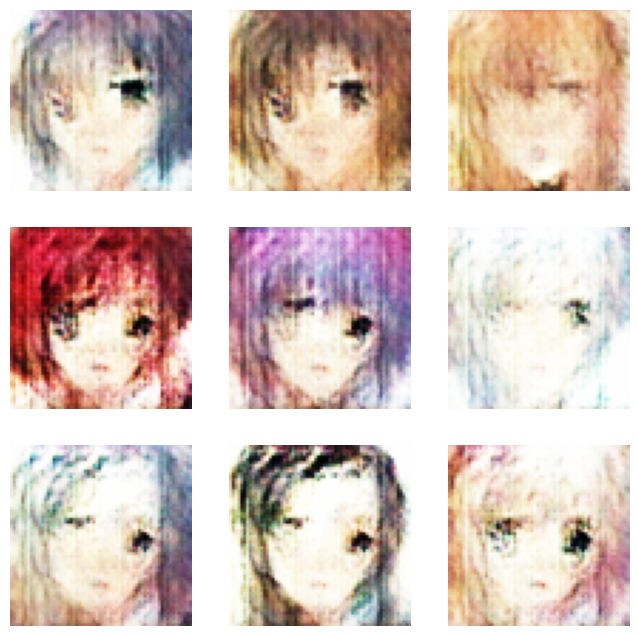

In [29]:
from numpy import clip
import tensorflow as tf
saved_model_directory = 'anime-faces'
anime_face_generator = tf.saved_model.load(saved_model_directory)

num_samples = 9
sample_noise = tf.random.normal([num_samples, latent_size])
sample_images = anime_face_generator(sample_noise)
sample_images = 0.5 * sample_images + 0.5  # Denormalize
sample_images = clip(sample_images, 0, 1)  # Clip values to [0, 1]

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i in range(num_samples):
    axs[i // 3, i % 3].imshow(sample_images[i])
    axs[i // 3, i % 3].axis('off')
plt.savefig('generated_anime-faces.png')
plt.show()



